In [4]:
!pip install graphviz numpy matplotlib


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

%matplotlib inline


In [6]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5


In [7]:
f(3.0)


20.0

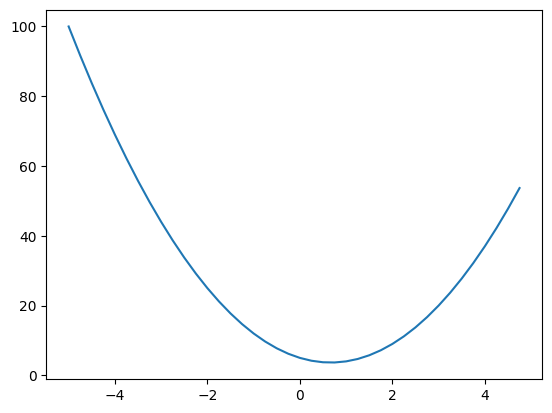

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [9]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x)) / h


0.0

In [85]:
class Value:
    def __init__(self, data: float, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)
                          ), "only supporting int/floats for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L


Value(data=-8.0)

In [11]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" %
                 (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


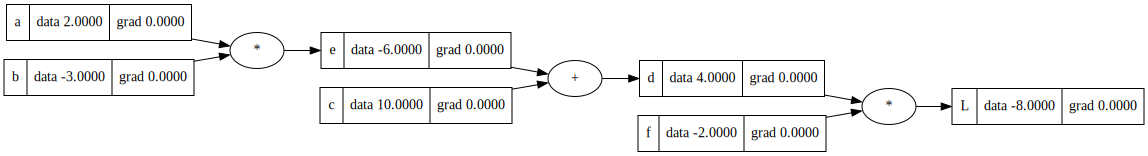

In [12]:
draw_dot(L)


In [13]:
L.grad = 1.0  # derivate of itself
f.grad = 4.0  # value of d, b.c. d(d * f)/df
d.grad = -2.0  # value of f, b.c. d(d * f)/dd
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0


In [14]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137335870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()


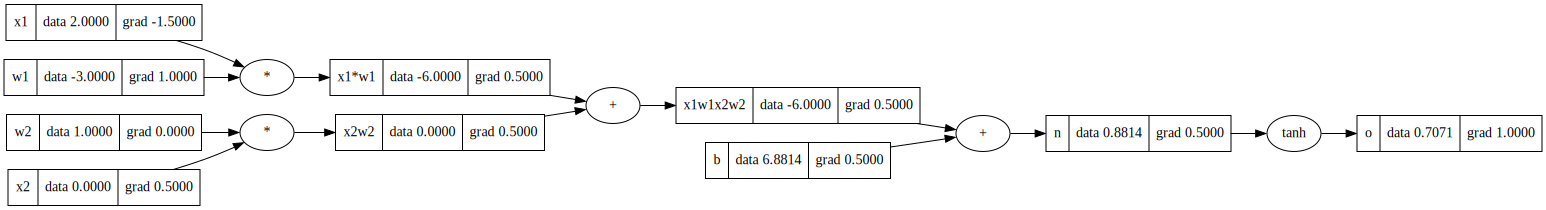

In [15]:
draw_dot(o)


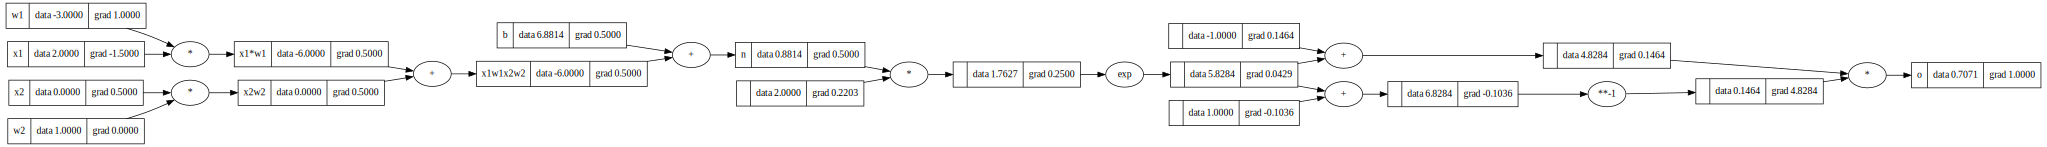

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137335870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)


In [17]:
!pip install torch


In [18]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88113735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7069886534797297
---
x2 0.5001670438509187
w2 0.0
x1 -1.500501131552756
w1 1.0003340877018374


In [189]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(1, -1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [190]:
x = [2.0, 3.0,  -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6007454607040303)

In [191]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [349]:
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.2 * p.grad

    print(k, loss.data)


0 5.138970761207861e-05
1 5.137403971153863e-05
2 5.135838113330735e-05
3 5.1342731869144184e-05
4 5.1327091910822084e-05
5 5.131146125012208e-05
6 5.129583987883421e-05
7 5.128022778875649e-05
8 5.1264624971699015e-05
9 5.124903141947832e-05
10 5.123344712392975e-05
11 5.121787207688664e-05
12 5.120230627019383e-05
13 5.118674969571551e-05
14 5.1171202345310024e-05
15 5.115566421086174e-05
16 5.114013528425034e-05
17 5.112461555737298e-05
18 5.110910502213611e-05
19 5.109360367045247e-05
20 5.107811149424251e-05
21 5.106262848544324e-05
22 5.1047154635993966e-05
23 5.103168993784921e-05
24 5.1016234382966636e-05
25 5.100078796331984e-05
26 5.0985350670886264e-05
27 5.096992249765482e-05
28 5.095450343563025e-05
29 5.0939093476810156e-05
30 5.0923692613215756e-05
31 5.0908300836877844e-05
32 5.0892918139825764e-05
33 5.0877544514107165e-05
34 5.086217995177574e-05
35 5.0846824444893344e-05
36 5.0831477985536556e-05
37 5.08161405657819e-05
38 5.080081217772573e-05
39 5.078549281346286e-

In [351]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9972322546063341),
 Value(data=-0.9970083906124345),
 Value(data=-0.9958411267655053),
 Value(data=0.996004827947753)]